# **Cardiomegaly Disease Classifier | MobileNetV2 & CNN**

<img height=1200 width=1000 src="https://entirelynourished.com/wp-content/uploads/2023/12/what-causes-an-enlarged-heart-1024x512.jpeg" />

# **Import Libraries**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

In [2]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

2025-02-20 21:33:43.099540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 21:33:43.106347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740062023.113943   27038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740062023.116227   27038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 21:33:43.124412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# **Retrieve Each Image with Its Corresponding Label**

In [5]:
train_data_path = 'data/rahimanshu/cardiomegaly-disease-prediction-using-cnn/versions/1/train/train'
filepaths =[]
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [6]:
test_data_path = 'data/rahimanshu/cardiomegaly-disease-prediction-using-cnn/versions/1/test/test'
filepaths =[]
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [7]:
train_df

,filepaths,label
0,data/rahimanshu/cardiomegaly-disease-predictio...,false
1,data/rahimanshu/cardiomegaly-disease-predictio...,false
2,data/rahimanshu/cardiomegaly-disease-predictio...,false
3,data/rahimanshu/cardiomegaly-disease-predictio...,false
4,data/rahimanshu/cardiomegaly-disease-predictio...,false
...,...,...
4433,data/rahimanshu/cardiomegaly-disease-predictio...,true
4434,data/rahimanshu/cardiomegaly-disease-predictio...,true
4435,data/rahimanshu/cardiomegaly-disease-predictio...,true
4436,data/rahimanshu/cardiomegaly-disease-predictio...,true


In [8]:
test_df

,filepaths,label
0,data/rahimanshu/cardiomegaly-disease-predictio...,false
1,data/rahimanshu/cardiomegaly-disease-predictio...,false
2,data/rahimanshu/cardiomegaly-disease-predictio...,false
3,data/rahimanshu/cardiomegaly-disease-predictio...,false
4,data/rahimanshu/cardiomegaly-disease-predictio...,false
...,...,...
4433,data/rahimanshu/cardiomegaly-disease-predictio...,true
4434,data/rahimanshu/cardiomegaly-disease-predictio...,true
4435,data/rahimanshu/cardiomegaly-disease-predictio...,true
4436,data/rahimanshu/cardiomegaly-disease-predictio...,true


# **Spliting and Preprocessing images**

In [9]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=45)

In [10]:
img_size = (224,224)
batch_size = 16
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size ,
                                      class_mode = 'categorical' ,
                                       color_mode = 'rgb' ,
                                       shuffle = True ,
                                       batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size , 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb' ,
                                       shuffle= True,
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test ,
                                      x_col= 'filepaths' ,
                                      y_col = 'label' ,
                                      target_size = img_size , 
                                      class_mode = 'categorical' ,
                                      color_mode= 'rgb' ,
                                      shuffle = False ,
                                      batch_size = batch_size)

Found 4438 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.


In [11]:
print("Train shape : " , train_gen.samples)
print("Validation shape : " , valid_gen.samples)
print("Test shape : " , test_gen.samples)

Train shape :  4438
Validation shape :  2219
Test shape :  2219


# **Display a Sample of Images with Their Corresponding Classes**

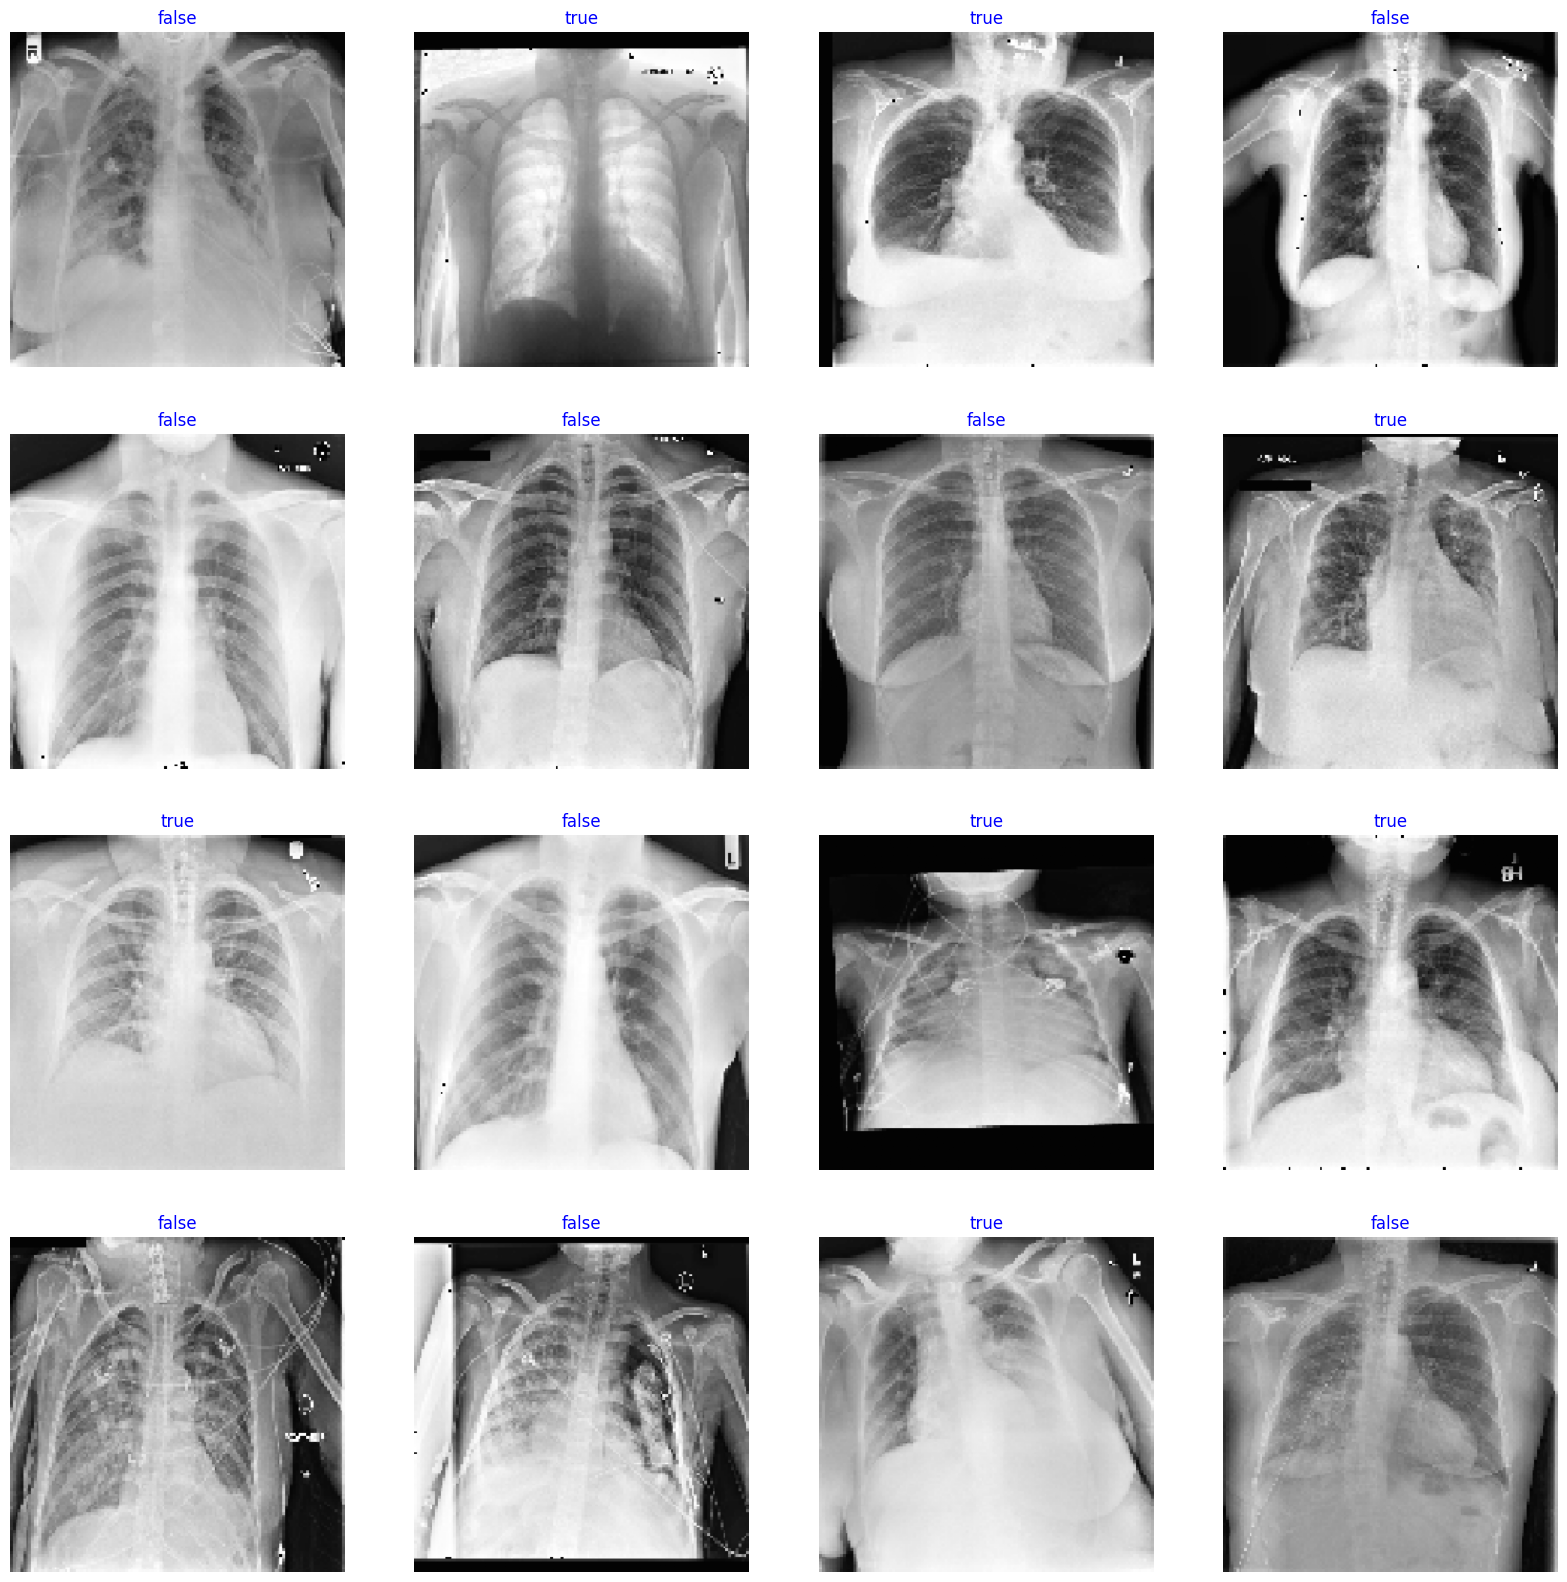

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

# **CNN Model Architecture** 
* ### This architecture is highly effective for various applications

<img height=1200 width=1000 src="https://www.medrxiv.org/content/medrxiv/early/2021/07/19/2021.07.15.21260605/F2.large.jpg" />

# **MobileNetV2 Architecture** 

<img height=1200 width=1000 src="https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png" />

# **Model Training**

In [13]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)
base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',
                                                  input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),  # Removed regularization
    Dropout(0.3),  # Reduced dropout
    Dense(num_class, activation='softmax')
])

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adamax(learning_rate=0.0005),  # Lower learning rate
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

I0000 00:00:1740062024.476621   27038 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22140 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,554 (9.89 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [14]:
Epochs = 15

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/15


I0000 00:00:1740062026.668535   27186 service.cc:148] XLA service 0x7fda64002bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740062026.668554   27186 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-20 21:33:46.721112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740062026.959136   27186 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/278 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5515 - loss: 0.9030

I0000 00:00:1740062028.456314   27186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


278/278 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5504 - loss: 0.8842 - val_accuracy: 0.6940 - val_loss: 0.5771
Epoch 2/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6424 - loss: 0.6635 - val_accuracy: 0.7539 - val_loss: 0.5050
Epoch 3/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7025 - loss: 0.5827 - val_accuracy: 0.8004 - val_loss: 0.4207
Epoch 4/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7436 - loss: 0.5194 - val_accuracy: 0.8342 - val_loss: 0.3861
Epoch 5/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7834 - loss: 0.4609 - val_accuracy: 0.8666 - val_loss: 0.3474
Epoch 6/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8034 - loss: 0.4315 - val_accuracy: 0.8914 - val_loss: 0.3119
Epoch 7/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8282 - loss: 0.3856 - val_accuracy: 0.9184 - val_loss: 0.2734
Epoch 8/15
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8348 - loss: 0.3691 - val_accuracy: 0.9347 - va

# **Model Evaluation**

In [15]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

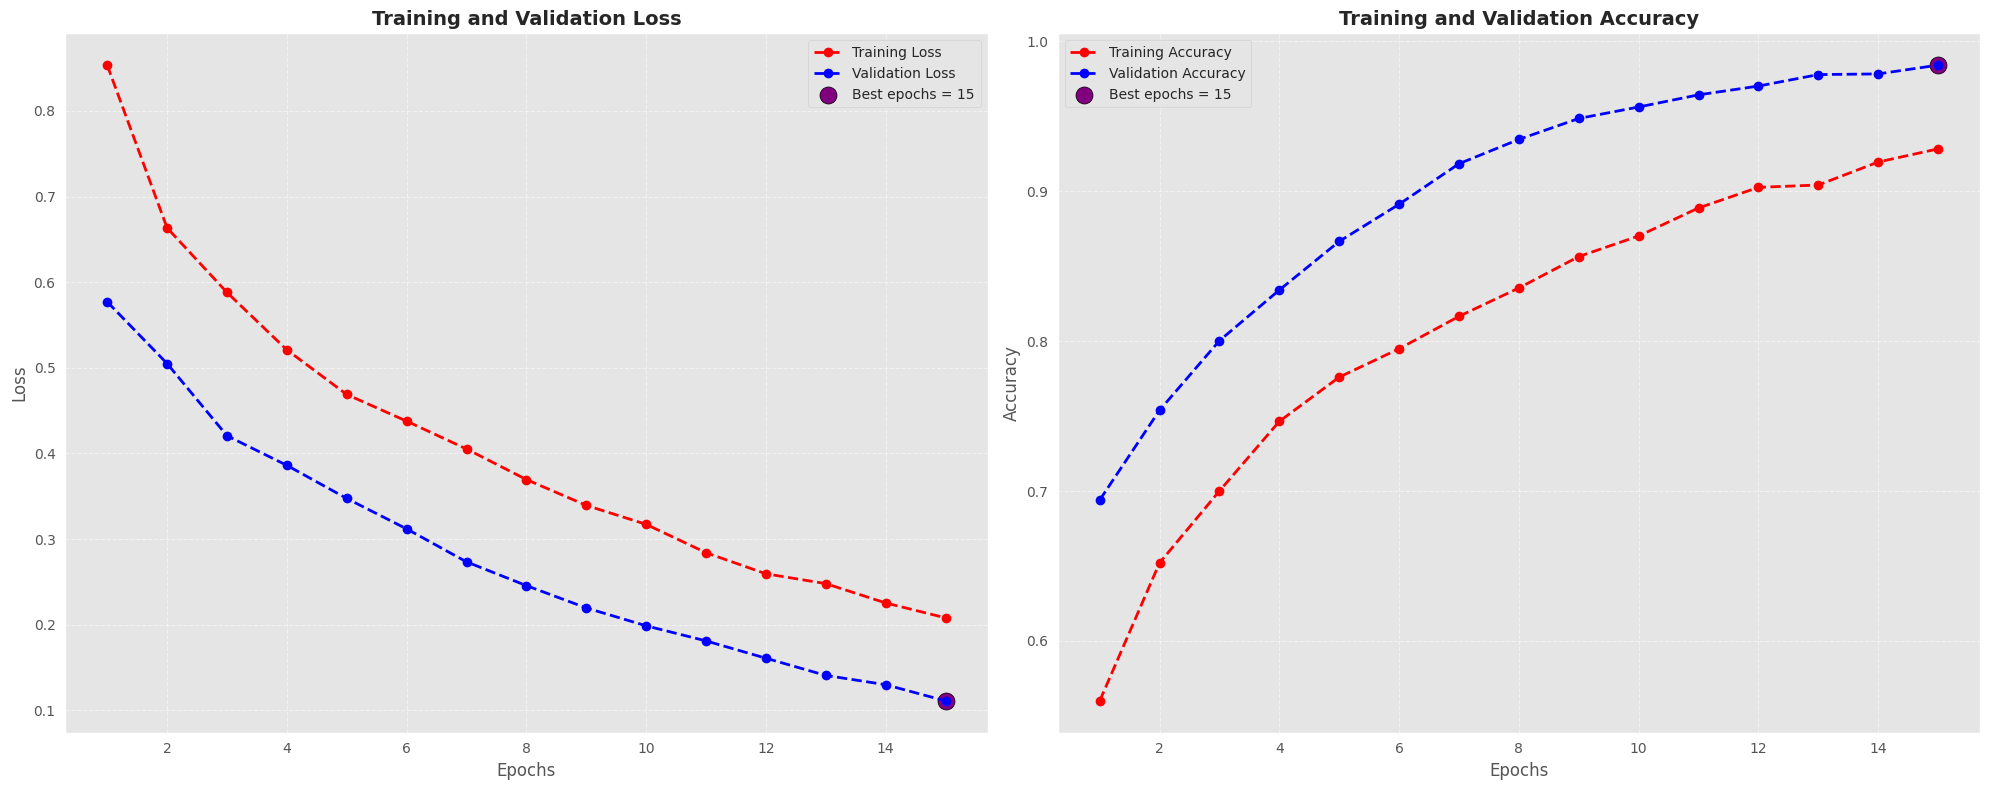

In [16]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()


In [17]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9804 - loss: 0.2112 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.1813
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0934
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9961 - loss: 0.0995
Train Loss:  0.1343604326248169
Train Accuracy:  0.98828125
--------------------
Validation Loss:  0.09386572986841202
Validation Accuracy:  0.9921875
--------------------
Test Loss:  0.09819132089614868
Test Accuracy:  0.9921875


# **Confusion Matrix**

139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


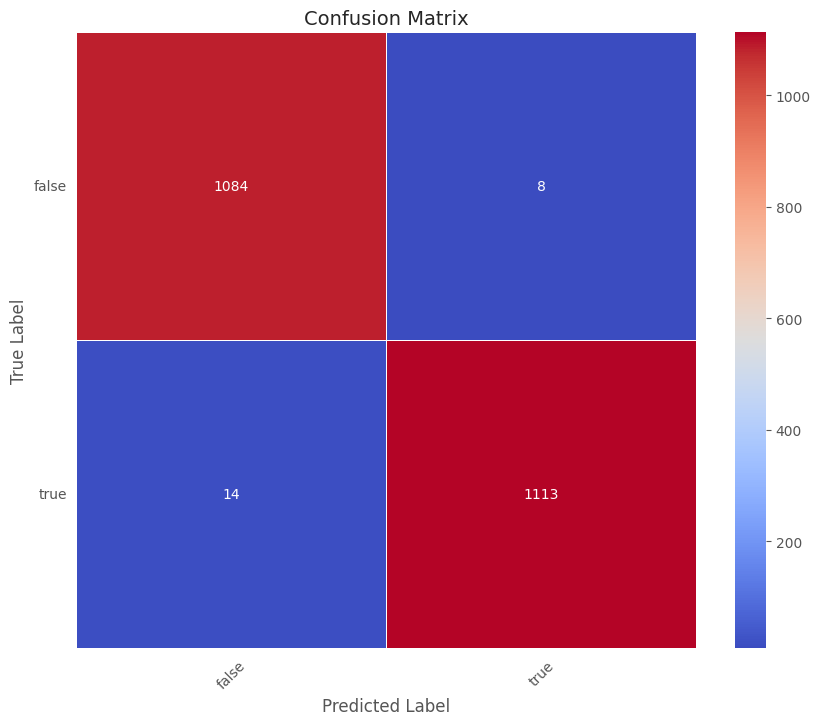

In [18]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# **Model Saving**

In [19]:
model.save("weight/model-15-16-best-d3.h5")

# **Fine-tuning Model**

In [36]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_layer
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu


In [37]:
n_freezes = 30

for layer in base_model.layers[:n_freezes]:
   layer.trainable = False
for layer in base_model.layers[n_freezes:]:
   layer.trainable = True

In [38]:
model.compile(optimizer=Adamax(learning_rate=1e-5),  # Lower learning rate
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,554 (9.89 MB)

 Trainable params: 2,535,346 (9.67 MB)

 Non-trainable params: 56,208 (219.56 KB)

In [39]:
Epochs = 30

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9794 - loss: 0.0607 - val_accuracy: 0.9878 - val_loss: 0.0327
Epoch 2/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9887 - loss: 0.0318 - val_accuracy: 0.9973 - val_loss: 0.0115
Epoch 3/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9918 - loss: 0.0258 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 4/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9848 - loss: 0.0392 - val_accuracy: 0.9995 - val_loss: 0.0028
Epoch 5/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9895 - loss: 0.0298 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 6/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9911 - loss: 0.0249 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 7/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9942 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/30
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9910 - loss: 0.0280 - val_acc

In [40]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3113e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4023e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7132e-04
Train Loss:  0.00023617893748451024
Train Accuracy:  1.0
--------------------
Validation Loss:  0.00017924371059052646
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0001624382275622338
Test Accuracy:  1.0


### **Confusion Matrix**

139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


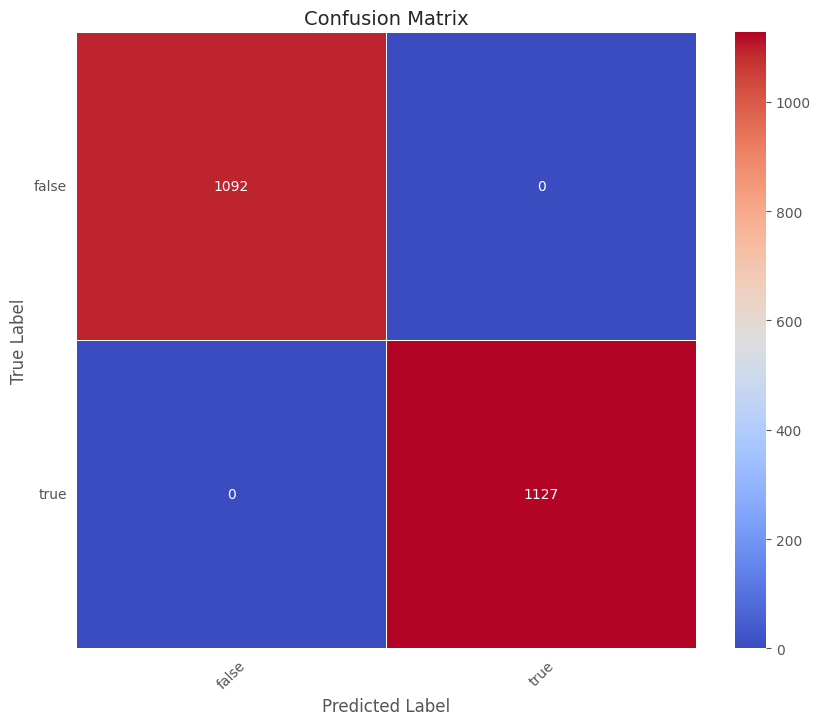

In [41]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## **Model Visualization**

In [42]:
# Load the saved model
model1 = tf.keras.models.load_model("weight/model-15-32-0005.h5")
model2 = tf.keras.models.load_model("weight/model-15-64-0005.h5")

# Evaluate the loaded model on the test data
model1_score = model1.evaluate(test_gen, steps=16, verbose=1)
model2_score = model2.evaluate(test_gen, steps=16, verbose=1)
print("Model 1 Test Loss: ", model1_score[0])
print("Model 1 Test Accuracy: ", model1_score[1])
print('-' * 20)
print("Model 2 Test Loss: ", model2_score[0])
print("Model 2 Test Accuracy: ", model2_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8352 - loss: 0.7733
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7336 - loss: 0.8201
Model 1 Test Loss:  0.5673840045928955
Model 1 Test Accuracy:  0.8671875
--------------------
Model 2 Test Loss:  0.724592387676239
Model 2 Test Accuracy:  0.76953125
